In [1]:
import os
import dotenv
import pandas as pd

from src.constants import *
from src.openai_client import *

open_ai_api_key = os.environ.get('OPENAI_API_KEY')
dotenv.load_dotenv()
import openai
from src.communication.messaging_service import SMSService
from src.communication.twilio_tool import NewTwilioConversationManager

C:\Users\dryha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Testing out .env credentials

### Testing Twilio

Sending a message to an arbitrary phone number

In [5]:
sms_test = SMSService()
your_phone_number = "+33647873573"
message_body = "Testons"
message = sms_test.send_message(your_phone_number,message_body)

### Testing OpenAI

In [ ]:
#Dummy example to communicate with GPT
openai.api_key = os.environ.get('OPENAI_API_KEY')

response = openai.ChatCompletion.create(model="gpt-4o",
                                        messages= [
    {"role": "user", "content": "Answer to me with the word Yeehee only"},
    {"role": "assistant", "content": "Yeehee!"},
    {"role": "user", "content": "You put an exclamation mark after that word, please remove it :)"},
    {"role": "assistant", "content": "Yeehee"},
    {"role": "user", "content": "That's perfect, you nailed it !"}
                                        ],
                                        temperature=1)

In [ ]:
#Printing the answer
print(response["choices"][0]["message"]["content"])

Thank you! If you need anything else, feel free to ask.


In [ ]:
response.choices[0].message['content']

'Thank you! If you need anything else, feel free to ask.'

### Running tests for the database

This first cell sets up a new database on which functions can be tested and troubleshot, if needed.

In [ ]:
from flask import Flask
import os
from src.db_session import init_db, session_scope
from src.data_manager.models import db, User 

app = Flask(__name__)

base_directory = os.path.abspath(os.getcwd())
project_directory = os.path.join(base_directory, '..', '..')
database_directory = os.path.join(project_directory, 'data')
database_directory = os.path.normpath(database_directory)

if not os.path.exists(database_directory):
    os.makedirs(database_directory)

database_filename = 'mydatabase.db'
database_path = os.path.join(database_directory, database_filename)
db_uri = 'sqlite:///' + database_path

app.config['SQLALCHEMY_DATABASE_URI'] = db_uri
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False

db.init_app(app)  
init_db(db_uri)

with app.app_context():
    print("Creating database tables...")
    db.create_all()
    print("Tables created successfully.")

Creating database tables...
Tables created successfully.


TBD : Sandbox cell to play with functions just below :

### Testing the MFR api / data managers.


In [ ]:
from export_cohort_data import (ExportCohortAnnotationsService,
                                MyFoodRepoService)

In [ ]:
host_mapping = {
                "local": MyFoodRepoService.LOCAL_HOST,
                "staging": MyFoodRepoService.STAGING_HOST,
                "production": MyFoodRepoService.PRODUCTION_HOST
            }

host = host_mapping.get('production')
myfoodrepo_service = MyFoodRepoService(host=host,
                                                   uid=os.getenv("MFR_UID"),
                                                   client=os.getenv("MFR_CLIENT"),
                                                   access_token=os.getenv("MFR_ACCESS_TOKEN"))

arg1 = os.environ.get(MFR_ENV_KEY)
arg2 = os.environ.get(MFR_COHORT_ID_KEY)

In [ ]:
export_service = ExportCohortAnnotationsService(myfoodrepo_service, arg2)
export_service.call()

2025-04-07 11:34:15,902 - myfoodrepo.data_manager.export_cohort_data - INFO - ⏱️ Total script time: 14.433277606964111 seconds


In [3]:
from src.data_manager.myfoodrepo_data_manager import load_data_from_csv
from src.utils.date_utils import convert_to_local_time
from src.utils.pandas_utils import delete_empty_rows


df = load_data_from_csv()
df = convert_to_local_time(df)
df = delete_empty_rows(df)

In [ ]:
from src.services.meal_grouping import group_by_intakeid

timestamp_columns = ['consumed_at','local_time']
text_columns = ['food_name']
value_columns = ['energy_kcal','fat','fatty_acids_saturated','carbohydrates','sugar','salt'
                    'fiber','calcium','iron','copper','fluoride','chloride','zinc','phosphorus',
                    'manganese','fatty_acids_polyunsaturated','alcohol','caffeine','glucose','glyocgen',
                    'lactose','starch','sodium','water','protein','protein_animal','protein_plant','energy_kj',
                    'cholesterol','energy_fiber_kj']

result = group_by_intakeid(
    df,
    columns_to_sum=value_columns,
    columns_to_min=timestamp_columns,
    columns_to_join=text_columns,
    dict_columns={
        'food_ids': ('food_name','food_id')}
)

In [ ]:
result.head()

,intake_id,energy_kcal,fat,fatty_acids_saturated,carbohydrates,sugar,calcium,iron,copper,fluoride,...,protein,protein_animal,protein_plant,energy_kj,cholesterol,energy_fiber_kj,consumed_at,local_time,food_name,food_ids
0,003ced1a-9d7d-4a51-8f77-fc08351f84b0,42.20,0.54,0.08,2.56,1.74,55.64,1.60,0.0,0.0,...,4.96,0.0,0.0,176.60,0.0,0.0,2024-06-16 10:17:36.343000+00:00,2024-06-16 12:17:36.343000+02:00,"Leafy salad (average), raw , Mushroom, stewed ...","{'Leafy salad (average), raw ': 'a140e64b-94ac..."
1,00994e42-2a3d-41b5-a457-8704e463e723,154.00,8.00,4.80,15.60,14.50,176.00,0.00,0.0,0.0,...,4.70,0.0,0.0,645.00,25.0,0.0,2024-07-02 18:19:39.251000+00:00,2024-07-02 20:19:39.251000+02:00,"Yogurt, vanilla, Espresso with coffee cream, n...","{'Yogurt, vanilla': 'd481a27c-c0a9-4f07-b9de-6..."
2,034a7f44-f2b9-4883-bda2-455c9ecff79b,911.45,6.69,1.19,137.74,6.72,277.30,12.31,0.0,0.0,...,50.18,0.0,0.0,3835.10,0.0,0.0,2024-06-17 19:22:28.060000+00:00,2024-06-17 21:22:28.060000+02:00,"Wholemeal pasta egg-free, cooked in salted wat...","{'Wholemeal pasta egg-free, cooked in salted w..."
3,0409eeb1-bc39-4b50-9db6-ca8ff7524a26,258.40,6.93,0.97,27.18,7.48,193.30,3.57,0.0,0.0,...,14.10,0.0,0.0,1081.30,0.0,0.0,2024-06-27 10:05:55.822000+00:00,2024-06-27 12:05:55.822000+02:00,"Hummus, Common bean (all types), mature seed, ...",{'Hummus': '470bb7b8-5ade-456b-8240-3f69693f21...
4,08608d27-f16c-48fb-8557-d12970443948,105.02,0.12,0.00,23.25,18.41,6.02,0.24,0.0,0.0,...,1.30,0.0,0.0,446.04,0.0,0.0,2024-06-17 06:25:57.148000+00:00,2024-06-17 08:25:57.148000+02:00,"Banana, raw","{'Banana, raw': '381fbe6b-3e30-4dc7-b4f5-96b40..."


In [ ]:
from sqlalchemy import create_engine
from src.constants import DATABASE_FILENAME, DATA_FOLDER_NAME
import os
import pandas as pd
from src.db_session import init_db, session_scope
base_directory = os.getcwd()
database_directory = os.path.join(base_directory, DATA_FOLDER_NAME)
database_path = os.path.join(database_directory, DATABASE_FILENAME)
youhou = 'sqlite:///' +  database_path
init_db(youhou)


In [ ]:
from src.data_manager.meal import health_summary_preprocessing
from src.db_session import init_db
import json

init_db(youhou)
keys = ["yYKBsLdnL","3ZmcaQgqs","2uFgY7rnK"]
users = ["1","2","3"]
output_dir = "user_meals/"
data_dir = "data/"


for key, user in zip(keys,users):
    df = health_summary_preprocessing(key)
    output_path = os.path.join(output_dir, f"user_{user}_meals.json")
    df.to_json(output_path, index=False)

In [ ]:
df = pd.read_csv("../mfr-chatbot/mfr_10_users.csv")
pd.set_option('display.max_columns',100)

In [ ]:
pd.set_option('display.max_columns', 50)
df2 = pd.read_json("user_meals/user_1_meals.json")

In [ ]:
from src.data_manager.nutritional_profiling import analyse_food_preferences

hehe = analyse_food_preferences("yYKBsLdnL")

In [5]:
base_directory = os.path.abspath(os.getcwd())
project_directory = os.path.join(base_directory, '..', '..')
database_directory = os.path.join(project_directory, 'data')
database_directory = os.path.normpath(database_directory)

2025-04-12 15:53:58,493 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO - Database Meals update process started...


In [ ]:
from src.data_manager.myfoodrepo_data_manager import load_data_from_csv
user_df = load_data_from_csv()

NameError: name 'load_data_from_csv' is not defined

In [1]:
import os
import dotenv
import pandas as pd

from src.constants import *
from src.openai_client import *

open_ai_api_key = os.environ.get('OPENAI_API_KEY')
dotenv.load_dotenv()
import openai
from src.communication.messaging_service import SMSService
from src.communication.twilio_tool import NewTwilioConversationManager

from src.config.config import create_app


app = create_app()

C:\Users\dryha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Creating database tables
Tables created successfully
2025-07-21 14:36:30,656 - myfoodrepo.scheduler - INFO - Scheduling reminders for all users...
2025-07-21 14:36:30,807 - myfoodrepo.scheduler - INFO - Job ID: fetch_meal_data, Trigger: interval[1:00:00]
2025-07-21 14:36:30,807 - myfoodrepo.scheduler - INFO - Job ID: partial_sync_0659, Hour: *
2025-07-21 14:36:30,813 - myfoodrepo.scheduler - INFO - Job ID: partial_sync_1159, Hour: *
2025-07-21 14:36:30,813 - myfoodrepo.scheduler - INFO - Job ID: partial_sync_1859, Hour: *
2025-07-21 14:36:30,813 - myfoodrepo.scheduler - INFO - Scheduler started successfully


In [12]:
from src.data_manager.user import get_all_users
from src.data_manager.message import get_all_messages
from src.data_manager.models import Message

with app.app_context():
    messages =  get_all_messages()
    users = get_all_users()



In [13]:
all_concerned_users = []
for user in users:
    user_id = user.id
    all_messages = [message for message in messages if message.user_id == user_id]
    curr_messages = [message for message in all_messages if message.role == 'assistant']
    for msg in all_messages :
        if 'recommended (0-50g)' in msg.content:
            #print(msg.content)
            all_concerned_users.append(msg)
        #elif 'Sugar daily intake is within the recommended range' in msg.content:
        #    all_concerned_users.append(msg)
        else:
            continue
            


In [14]:
len(all_concerned_users)

0

In [10]:
from src.config.logging_config import Logger
from src.db_session import session_scope
from tqdm.notebook import tqdm

In [11]:
update_sugar_levels(all_concerned_users)

modifying sugar levels:   0%|          | 0/163 [00:00<?, ?it/s]

('Successfully updated 139 messages', 200)

In [8]:
import re

def update_sugar_levels(messages):
    """
    Updates the sugar recommendation text in message content from fixed grams to percentage of calories.

    Args:
        messages: List of message objects to update.

    Returns:
        tuple: A tuple containing a message string and an HTTP status code.
    """
    with session_scope() as session:
        try:
            updated_count = 0
            
            for msg in tqdm(messages, desc=f"modifying sugar levels"):
                curr_msg = session.query(Message).filter_by(id=msg.id).first()
                if not curr_msg:
                    continue
                
                # Replace the sugar recommendation text using regex
                # This pattern matches "Sugar daily intake is high at [anything] (recommended: 0-50g)" 
                # and replaces it with the new recommendation
                pattern = r'(Sugar daily intake is high at [^(]*)\(recommended: 0-50g\)'
                replacement = r'\1(recommended: 0-20% of calories)'
                
                new_content = re.sub(pattern, replacement, curr_msg.content)
                
                # Only update if content actually changed
                if new_content != curr_msg.content:
                    curr_msg.content = new_content
                    updated_count += 1
            
            session.commit()
            return f"Successfully updated {updated_count} messages", 200
            
        except Exception as e:
            session.rollback()
            return f"Error updating messages: {str(e)}", 500

In [3]:
import win32com.client as win32

from src.communication.email_manager import send_study_end_mail, send_study_report_mail

#outlook = win32.Dispatch('outlook.application')
#user_1 = get_user("+41786458918")
#send_study_report_mail(user_1,outlook,"romain.rochepeau@epfl.ch",app)

In [4]:
#twilio_conv_manager = NewTwilioConversationManager(sms_test)
#with app.app_context():
#    twilio_conv_manager.send_goodbye_message("+33647873573")

In [5]:
#import win32com.client as win32
#
#from src.utils.localization_utils import get_localized_string
#outlook = win32.Dispatch('outlook.application')
#mail = outlook.CreateItem(0)
#mail.To = 'romain.rochepeau@epfl.ch'
#with app.app_context():
#    mail.Subject = get_localized_string("mail-subject", "it")
#    mail.HTMLBody = get_localized_string("mail-html-body", "it")
#
#mail.Send()

from src.communication.email_manager import send_all_study_end_mails, send_study_report_mail

#send_all_study_end_mails(app)


In [6]:
from src.data_manager.nutritional_profiling import *
from src.data_manager.user import get_user
from src.communication.reminder_manager import send_reminder,generate_personalised_reminder, send_reminder
from src.prompts.prompts_templates import HEI_EXPLANATION,AI_DISCLAIMER
from src.data_manager.health_summary.health_summary import generate_health_summary, build_nutrition_pdf, load_data
from src.data_manager.myfoodrepo_data_manager import healthy_index_preprocessing
from src.data_manager.user import get_all_users


#user_1=get_user("+41764928279")
##generate_personalised_reminder(user_1,"Breakfast",False,timedelta.max,timedelta(minutes=60),False,app,None)
#user_food_recap = healthy_index_preprocessing(user_1)
#_,_,_,_, summaries = generate_health_summary(user_1.id,user_1.phone_number,user_1.myfoodrepo_key,user_1.diet_goal,user_1.language,user_food_recap)
#
#figure_path = f"output/figures/{user_1.id}_nutrition_dashboard.png"
#output_pdf_path = f"output/{user_1.id}_nutrition_report.pdf"
#
#build_nutrition_pdf(user_1.id, summaries, figure_path, output_pdf_path,user_1.language,ai_disclaimer=None,hei_explanation=None)

In [7]:
#import win32com.client as win32
#outlook = win32.Dispatch('outlook.application')
#send_study_report_mail(user_1,outlook,"marcel.salathe@epfl.ch",app)

In [8]:
#all_meals = get_all_meals()

In [9]:
from src.prompts.prompts_templates import HEI_EXPLANATION,AI_DISCLAIMER
from src.data_manager.health_summary.health_summary import generate_health_summary, build_nutrition_pdf, load_data
from src.data_manager.myfoodrepo_data_manager import healthy_index_preprocessing
from src.data_manager.user import get_all_users


def generate_health_summaries():
    with app.app_context():
        all_users = get_all_users()
    for user in all_users :
        if (not user.study_ended) or (user.last_meal_log == None) :
            continue;
        figure_path = f"output/figures/{user.id}_nutrition_dashboard.png"
        output_pdf_path = f"output/{user.id}_nutrition_report.pdf"
        if os.path.exists(output_pdf_path):
            print(f"user{user.id} report already exists, we skip")
        else:
            user_food_recap = healthy_index_preprocessing(user)
            _,_,_,_, summaries = generate_health_summary(user.id,user.phone_number,user.myfoodrepo_key,user.diet_goal,user.language,user_food_recap)
            figure_path = f"output/figures/{user.id}_nutrition_dashboard.png"
            output_pdf_path = f"output/new_ones/{user.id}_nutrition_report.pdf"
            build_nutrition_pdf(user.id, summaries, figure_path, output_pdf_path,user.language,ai_disclaimer=None,hei_explanation=None)


generate_health_summaries()

#user_food_recap = healthy_index_preprocessing(user_1)
#_,_,_,_, summaries = generate_health_summary(user_1.id,user_1.phone_number,user_1.myfoodrepo_key,user_1.diet_goal,user_1.language,user_food_recap)
#
#figure_path = f"output/figures/{user_1.id}_nutrition_dashboard.png"
#output_pdf_path = f"output/{user_1.id}_nutrition_report.pdf"
#
#build_nutrition_pdf(user_1.id, summaries, figure_path, output_pdf_path,user_1.language,ai_disclaimer=None,hei_explanation=None)

user3 report already exists, we skip
user4 report already exists, we skip
user6 report already exists, we skip
user7 report already exists, we skip
2025-07-16 22:11:54,284 - myfoodrepo.models.user - INFO - User found: <User 9>
2025-07-16 22:11:54,291 - myfoodrepo.models.message - INFO - 🟢 db_add_message() called for user 9 with role system
2025-07-16 22:11:54,293 - myfoodrepo.models.message - INFO - Prepared to insert message for user: 9, with role: system

2025-07-16 22:11:54,399 - myfoodrepo.models.user - INFO - User found: <User 9>
2025-07-16 22:11:54,404 - myfoodrepo.models.message - INFO - 🟢 db_add_message() called for user 9 with role system
2025-07-16 22:11:54,407 - myfoodrepo.models.message - INFO - Prepared to insert message for user: 9, with role: system

2025-07-16 22:11:54,429 - myfoodrepo.models.user - INFO - User found: <User 9>
2025-07-16 22:11:54,535 - myfoodrepo.models.user - INFO - User found: <User 9>
2025-07-16 22:11:54,541 - myfoodrepo.models.user - INFO - User fou

c:\Users\dryha\Desktop\Master Project\myfoodrepo-llm-test\src\utils\health_plot_utils.py:417: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(plot_data['eaten_time'], plot_data[size_metric], 5)


2025-07-16 22:14:39,774 - myfoodrepo.models.user - INFO - User found: <User 84>
2025-07-16 22:14:39,779 - myfoodrepo.models.message - INFO - 🟢 db_add_message() called for user 84 with role system
2025-07-16 22:14:39,781 - myfoodrepo.models.message - INFO - Prepared to insert message for user: 84, with role: system

2025-07-16 22:14:39,843 - myfoodrepo.models.user - INFO - User found: <User 84>
2025-07-16 22:14:39,848 - myfoodrepo.models.message - INFO - 🟢 db_add_message() called for user 84 with role system
2025-07-16 22:14:39,850 - myfoodrepo.models.message - INFO - Prepared to insert message for user: 84, with role: system

2025-07-16 22:14:39,866 - myfoodrepo.models.user - INFO - User found: <User 84>
2025-07-16 22:14:39,884 - myfoodrepo.models.user - INFO - User found: <User 84>
2025-07-16 22:14:39,890 - myfoodrepo.models.user - INFO - User found: <User 84>
2025-07-16 22:15:03,975 - myfoodrepo.models.user - INFO - User found: <User 84>
2025-07-16 22:15:03,979 - myfoodrepo.models.me

In [ ]:
#users = [get_user("+33647873573"),get_user("+41772782429"),get_user("+41799018790"),get_user("+33787287007"),
#         get_user("+33695923502"),get_user("+41793743892"),get_user("+33646242995"),get_user("+41765453738"),
#         get_user("+41779972085")]
#
#responses = []
#
#for user in users :
#    responses.append(generate_personalised_reminder(user,"Breakfast",False,timedelta.max,timedelta(minutes=60),False,app,None))

In [ ]:
#user_1=get_user("+33647873573")
#send_reminder(user_1,"Lunch",app,8)

In [7]:
calculate_eating_consistency(user_1)

{'logging_rate': 0.6086956521739131,
 'avg_meals_per_day': 2.2857142857142856,
 'breakfast_frequency': 0.42857142857142855,
 'lunch_frequency': 0.5714285714285714,
 'snack_frequency': 0.07142857142857142,
 'dinner_frequency': 0.7857142857142857,
 'night_snack_frequency': 0.0,
 'current_streak': 0,
 'max_streak': 11}

In [4]:
user_2 = get_user("2")
user_3 = get_user("3")
user_4 = get_user("4")
user_5 = get_user("5")
user_6 = get_user("6")
user_7 = get_user("7")


2025-04-16 15:48:27,529 - myfoodrepo.models.user - INFO - User found: <User 2>
2025-04-16 15:48:27,534 - myfoodrepo.models.user - INFO - User found: <User 3>
2025-04-16 15:48:27,539 - myfoodrepo.models.user - INFO - User found: <User 4>
2025-04-16 15:48:27,543 - myfoodrepo.models.user - INFO - User found: <User 5>
2025-04-16 15:48:27,549 - myfoodrepo.models.user - INFO - User found: <User 6>
2025-04-16 15:48:27,555 - myfoodrepo.models.user - INFO - User found: <User 7>


In [ ]:
from src.data_manager.myfoodrepo_data_manager import healthy_index_preprocessing
users = [user_2, user_3, user_4, user_5,user_6,user_7]

for idx, user in enumerate(users, start=2):
    user_df = healthy_index_preprocessing(user)
    user_df.to_json(f"data/user_{idx}_foods.json")

Run time of job "fetch_meal_data (trigger: interval[2:00:00], next run at: 2025-04-16 19:39:34 CEST)" was missed by 0:38:04.372661


2025-04-16 19:39:34,654 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO - Database Meals update process started...
2025-04-16 19:40:08,067 - myfoodrepo.data_manager.export_cohort_data - INFO - ⏱️ Total script time: 33.3749361038208 seconds
2025-04-16 19:40:08,070 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO - The cohort annotation .csv file was succesfully downloaded!
2025-04-16 19:40:08,400 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO - No newly logged meals found for user 6
2025-04-16 19:40:08,418 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO - The most recent log meal for user 6 is 2024-07-03 21:11:00
2025-04-16 19:40:08,524 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO - No newly logged meals found for user 2
2025-04-16 19:40:08,535 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO - The most recent log meal for user 2 is 2024-06-21 12:10:00
2025-04-16 19:40:08,871 - myfoodrepo.data_manager.myfoodrepo_data_manager - INFO

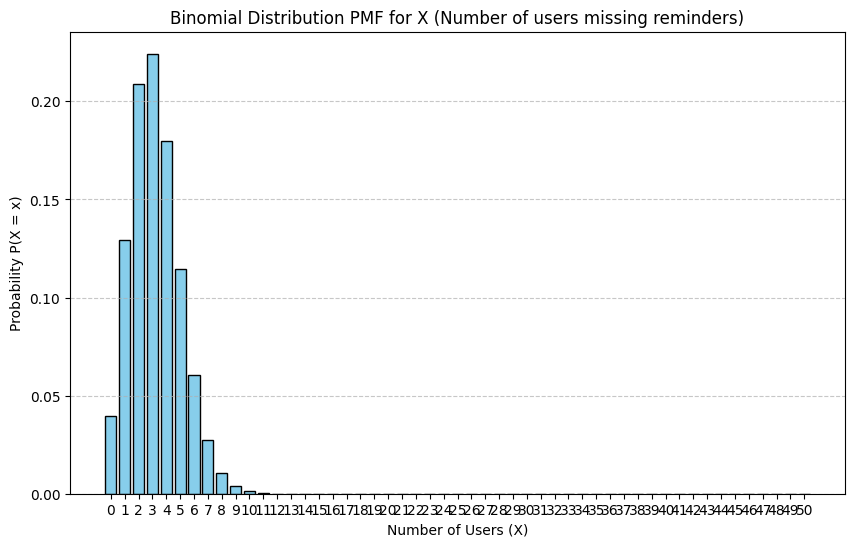

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom

# Parameters
n = 200
p = 0.016


x_values = np.arange(0, 51)

binom_probabilities = binom.pmf(x_values, n, p)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(x_values, binom_probabilities, color='skyblue', edgecolor='black')
plt.title('Binomial Distribution PMF for X (Number of users missing reminders)')
plt.xlabel('Number of Users (X)')
plt.ylabel('Probability P(X = x)')
plt.xticks(x_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




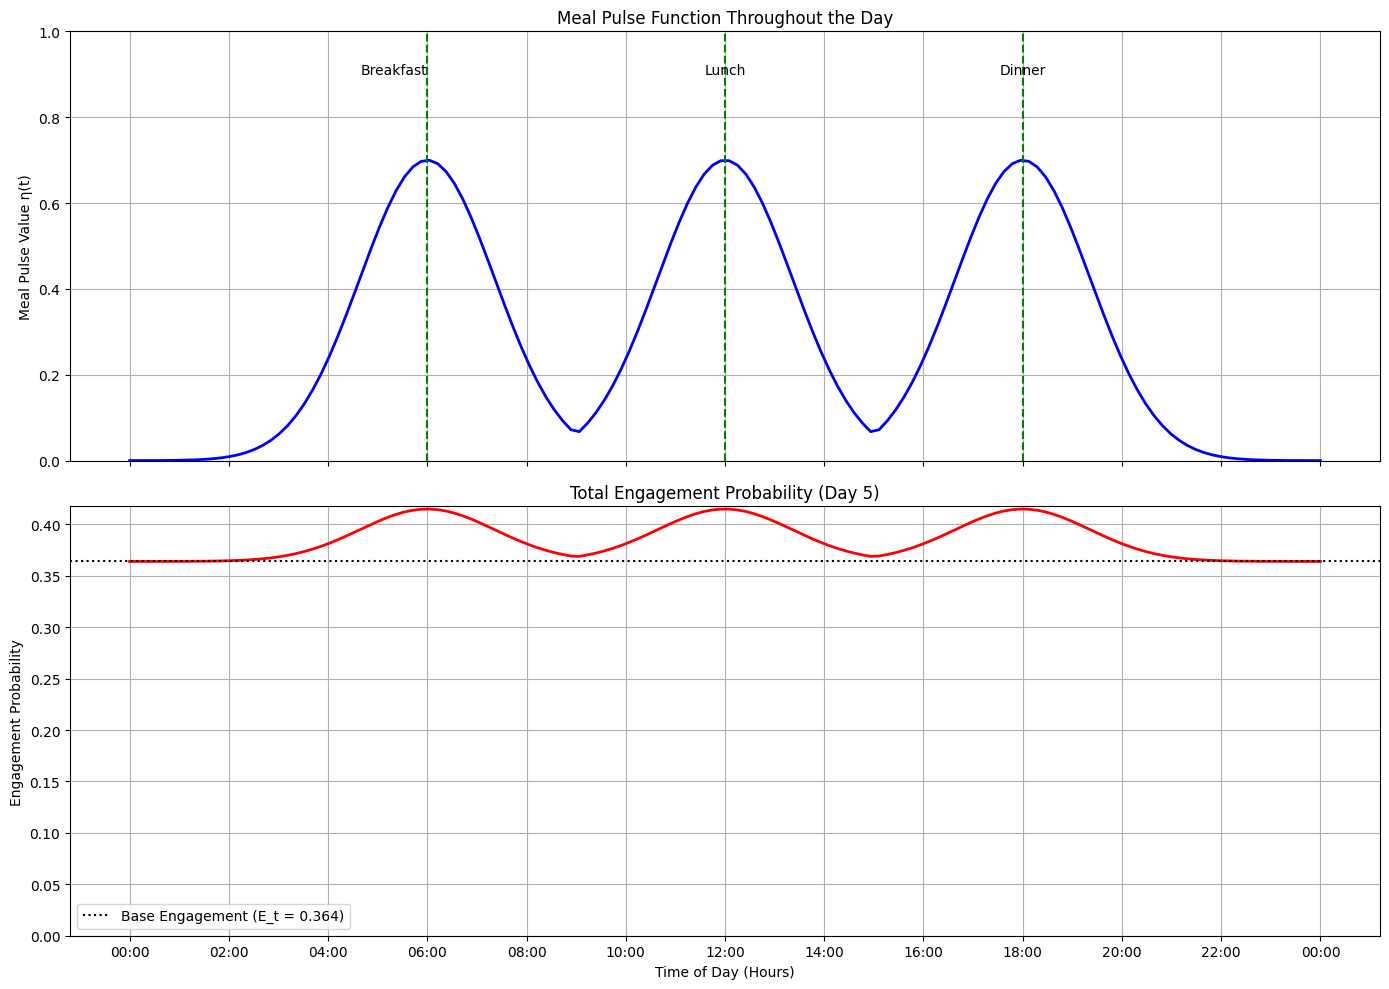

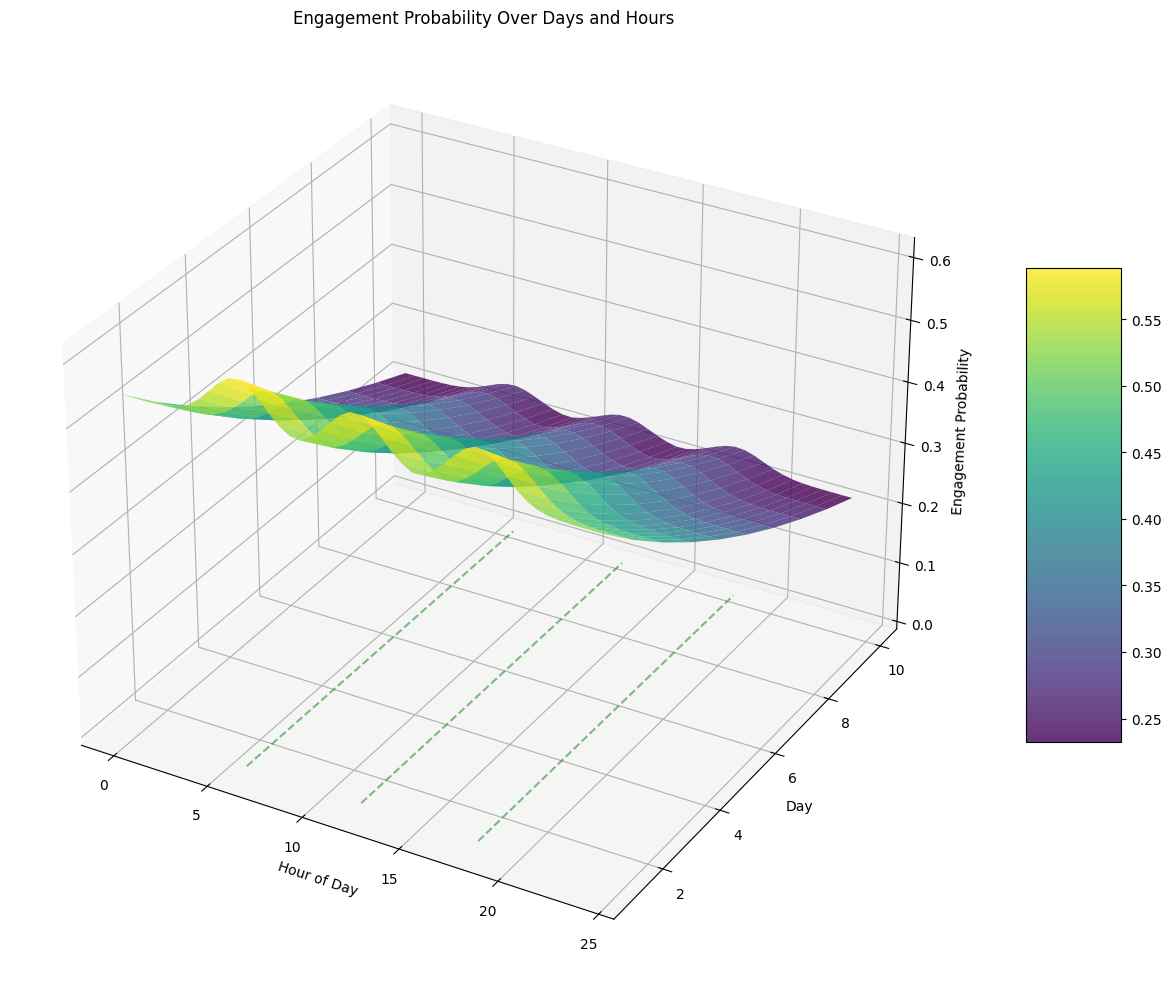

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
import datetime as dt

def meal_pulse(t):
    """
    Calculate the meal pulse value for a given time (as fraction of day)
    """
    # Convert t (days) to time within day (0-1)
    time_of_day = t % 1.0
    
    # Define meal times (as fraction of day)
    breakfast = 0.25  # ~6am
    lunch = 0.5       # ~12pm
    dinner = 0.75     # ~6pm
    
    # Create pulses around meal times
    meal_width = 0.08  # Width of meal time pulse
    breakfast_pulse = np.exp(-((time_of_day - breakfast) / meal_width)**2)
    lunch_pulse = np.exp(-((time_of_day - lunch) / meal_width)**2)
    dinner_pulse = np.exp(-((time_of_day - dinner) / meal_width)**2)
    
    # Combined meal effect without noise for visualization clarity
    pulse = 0.7 * max(breakfast_pulse, lunch_pulse, dinner_pulse)
    
    return pulse  # No noise or clipping for visualization

# Create time points for one day (in 10-minute intervals)
minutes_per_day = 24 * 60
time_points = np.linspace(0, 1, minutes_per_day // 10)
base_date = dt.datetime(2025, 1, 1)
times = [base_date + dt.timedelta(days=t) for t in time_points]

# Calculate meal pulse values (no random noise for clarity)
pulse_values = [meal_pulse(t) for t in time_points]

# Calculate total engagement probability throughout the day
# Assume this is day 5 of the simulation
day = 5
p0 = 0.6
beta = 0.1
gamma = 0.2

E_t = p0 * np.exp(-beta * day)  # Base engagement (constant throughout day)
R_values = [1 + gamma * pulse for pulse in pulse_values]  # Re-engagement modifier
engagement_prob = [E_t * R for R in R_values]  # Total engagement probability

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot meal pulse function η(t)
ax1.plot(times, pulse_values, 'b-', linewidth=2)
ax1.set_ylabel('Meal Pulse Value η(t)')
ax1.set_title('Meal Pulse Function Throughout the Day')
ax1.grid(True)
ax1.set_ylim(0, 1)

# Mark meal times
meal_times = [
    base_date + dt.timedelta(days=0.25),  # breakfast
    base_date + dt.timedelta(days=0.5),   # lunch
    base_date + dt.timedelta(days=0.75)   # dinner
]
meal_labels = ["Breakfast", "Lunch", "Dinner"]

for i, (time, label) in enumerate(zip(meal_times, meal_labels)):
    ax1.axvline(x=time, color='g', linestyle='--')
    ax1.text(time, 0.9, label, horizontalalignment='right' if i == 0 else 'center')

# Plot total engagement probability
ax2.plot(times, engagement_prob, 'r-', linewidth=2)
ax2.set_ylabel('Engagement Probability')
ax2.set_title(f'Total Engagement Probability (Day {day})')
ax2.grid(True)
ax2.set_ylim(bottom=0)

# Format x-axis to show hours
ax2.xaxis.set_major_locator(HourLocator(interval=2))
ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax2.set_xlabel('Time of Day (Hours)')

# Add base engagement line for reference
ax2.axhline(y=E_t, color='k', linestyle=':', label=f'Base Engagement (E_t = {E_t:.3f})')
ax2.legend()

plt.tight_layout()
plt.show()

# Now let's create a 3D visualization of how this changes over multiple days
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for days and time of day
days_to_show = 10
days_range = np.arange(1, days_to_show + 1)
times_of_day = np.linspace(0, 1, 48)  # 48 points throughout day

X, Y = np.meshgrid(times_of_day, days_range)
Z = np.zeros_like(X)

# Calculate engagement probability for each point
for i, day in enumerate(days_range):
    for j, tod in enumerate(times_of_day):
        E_t = p0 * np.exp(-beta * day)
        R_t = 1 + gamma * meal_pulse(tod)
        Z[i, j] = E_t * R_t

# Convert X to hour format for better visualization
X_hours = X * 24

# Create the surface plot
surf = ax.plot_surface(X_hours, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Add labels and colorbar
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day')
ax.set_zlabel('Engagement Probability')
ax.set_title('Engagement Probability Over Days and Hours')

# Add meal time indicators
for hour in [6, 12, 18]:  # Meal hours
    ax.plot([hour, hour], [1, days_to_show], [0, 0], 'g--', alpha=0.5)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

C:\Users\dryha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


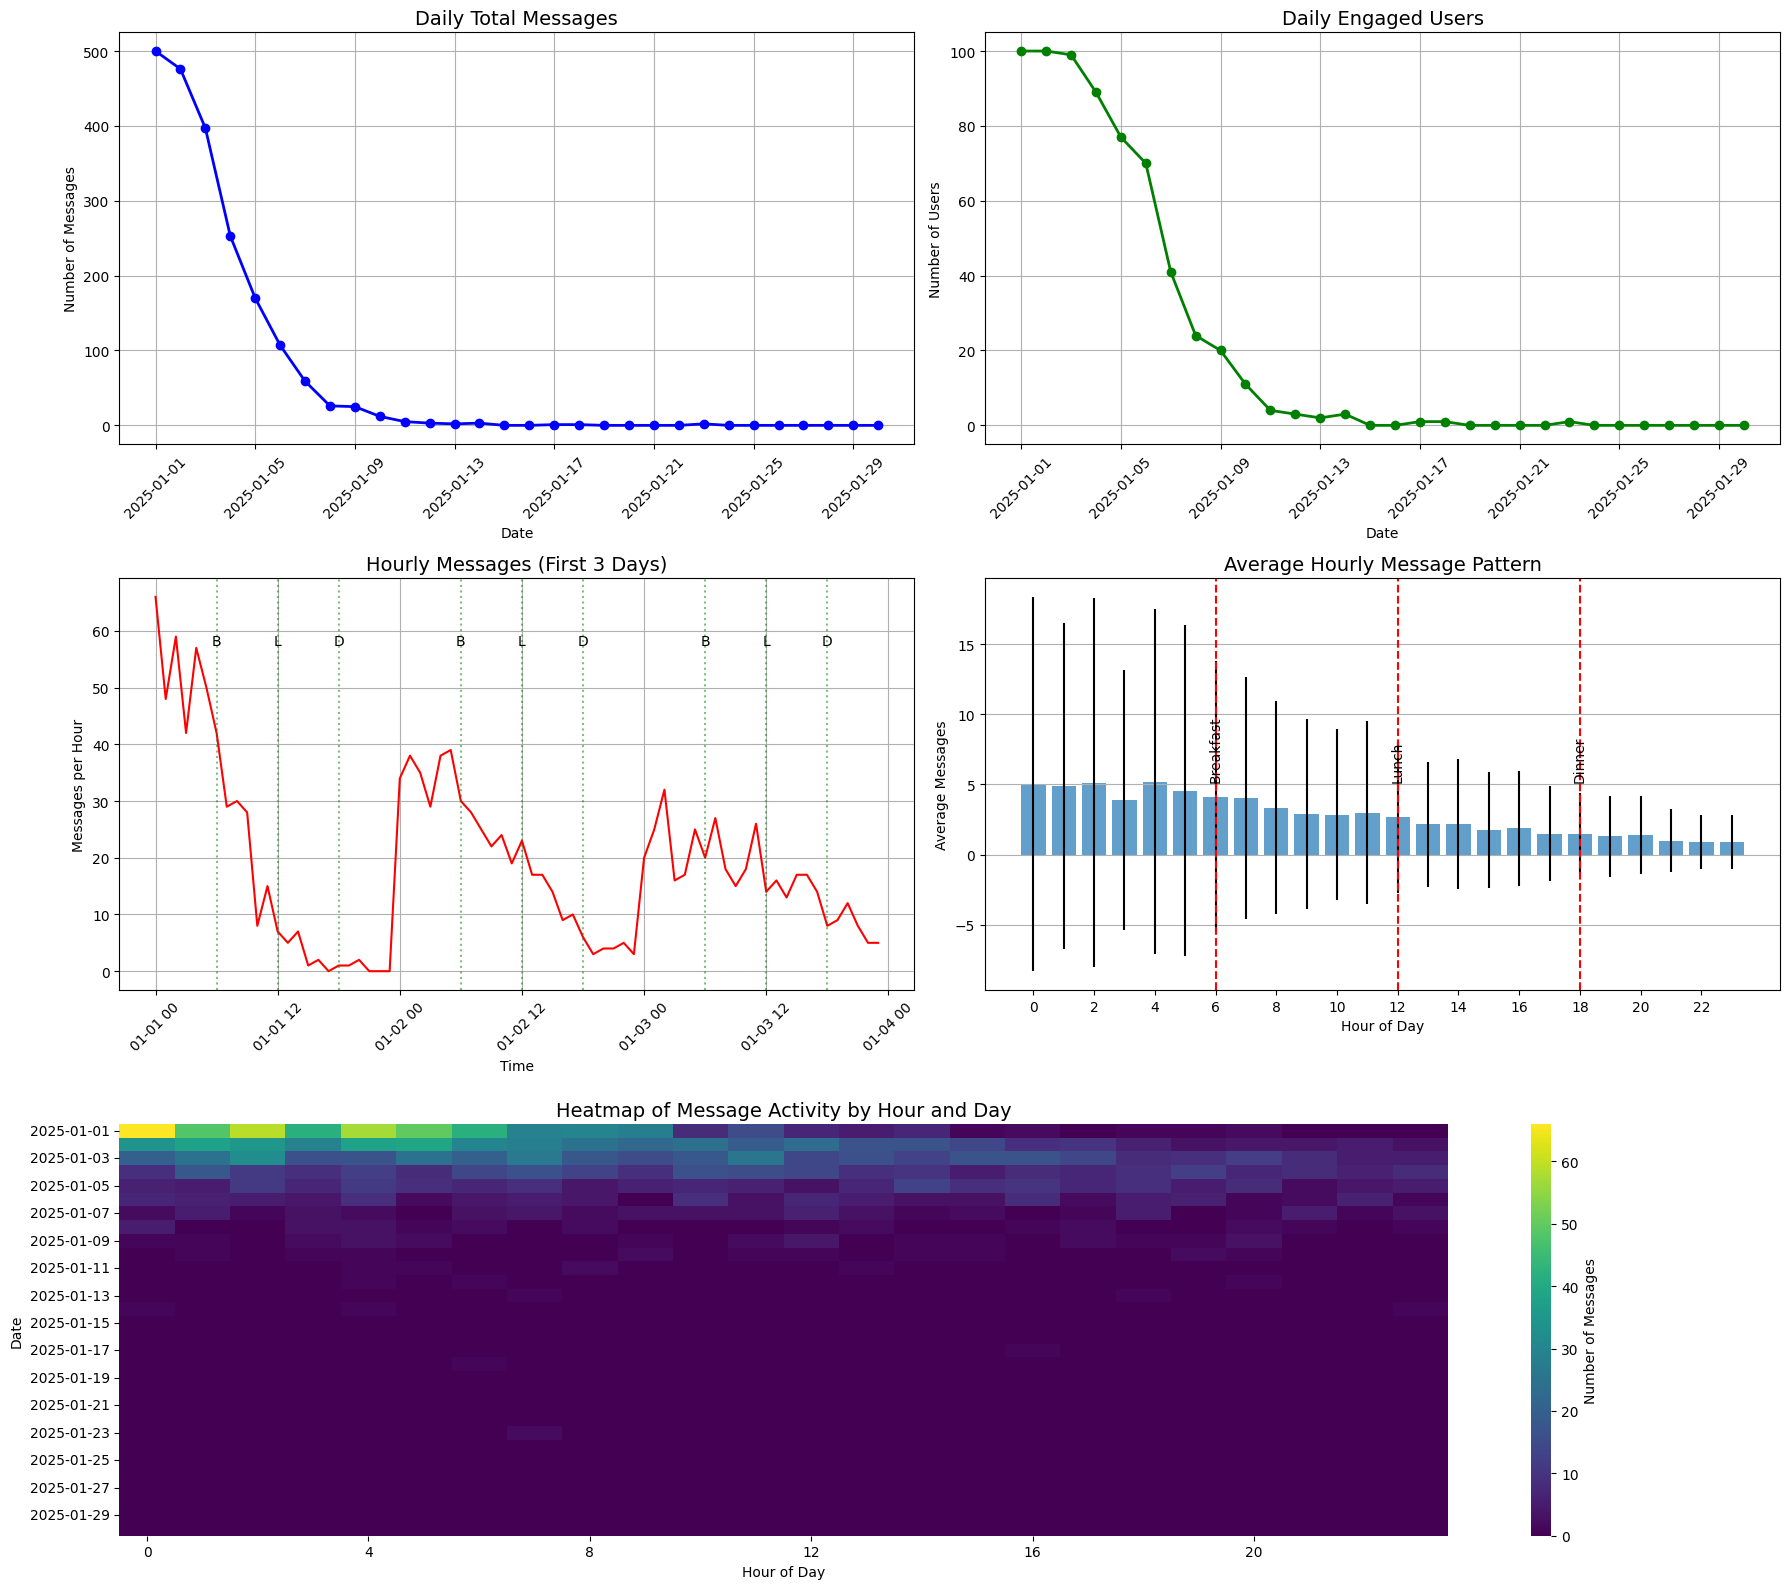

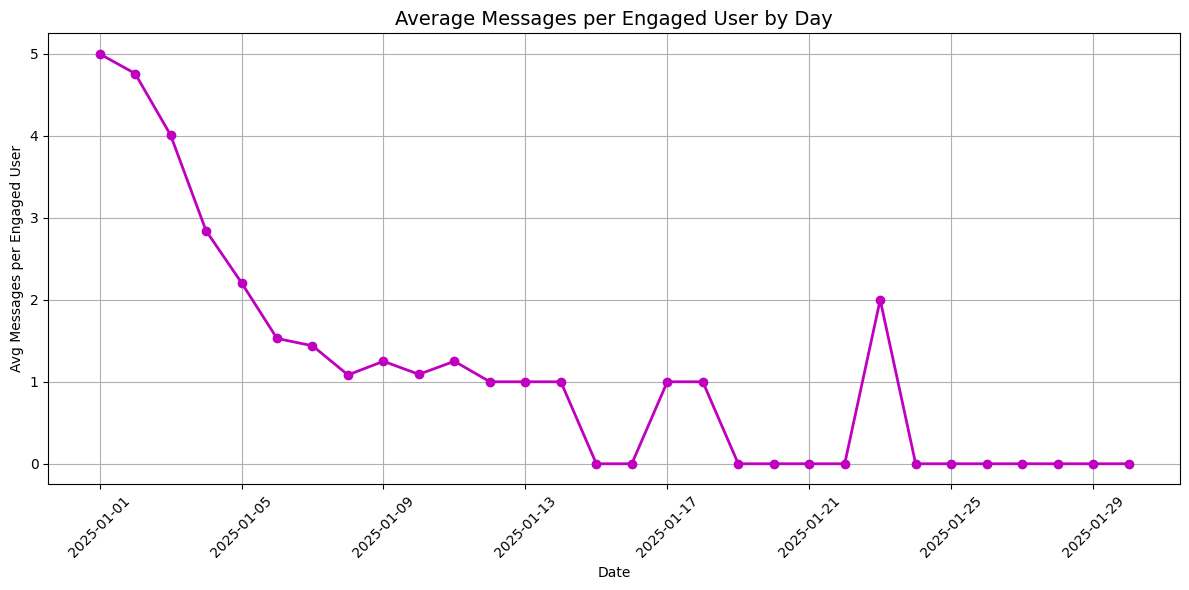

Simulation completed and visualizations created.
Total messages sent over 30 days: 2042.0
Average daily messages: 68.07
Peak day had 500.0 messages
Average messages per engaged user: 1.12


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
import datetime as dt
import pandas as pd
import seaborn as sns

# Simulation parameters
days = 30
num_users = 100
p0 = 0.9        # Initial engagement probability
beta = 0.5  # Engagement decay rate
q = 0.9        # Geometric stop probability (controls avg messages per engaged user)
gamma = 0.2     # Meal-time re-engagement modulation strength
max_messages_per_user_per_day = 5  # Daily message limit per user

# Helper: truncated geometric sample (1 to 10 messages)
def truncated_geometric(q, size=1):
    samples = []
    for _ in range(size):
        m = 1
        while m < 10 and np.random.rand() > q:
            m += 1
        samples.append(m)
    return np.array(samples)

# Meal pulse function with three distinct meal times per day
def meal_pulse(t):
    # Convert t (days) to time within day (0-1)
    time_of_day = t % 1.0
    
    # Define meal times (as fraction of day)
    breakfast = 0.25  # ~6am
    lunch = 0.5       # ~12pm
    dinner = 0.75     # ~6pm
    
    # Create pulses around meal times
    meal_width = 0.08  # Width of meal time pulse
    breakfast_pulse = np.exp(-((time_of_day - breakfast) / meal_width)**2)
    lunch_pulse = np.exp(-((time_of_day - lunch) / meal_width)**2)
    dinner_pulse = np.exp(-((time_of_day - dinner) / meal_width)**2)
    
    # Combined meal effect with some noise
    pulse = 0.7 * max(breakfast_pulse, lunch_pulse, dinner_pulse)
    noise = np.random.normal(0, 0.05)
    
    return np.clip(pulse + noise, 0, 1)

# Run simulation with hourly resolution
hours_per_day = 24
time_steps = days * hours_per_day

# Create arrays to store results
hourly_messages = np.zeros(time_steps)
hourly_engaged_users = np.zeros(time_steps)
user_daily_messages = np.zeros((days, num_users), dtype=int)

# Additional tracking for detailed analysis
hourly_engagement_prob = np.zeros(time_steps)
meal_effect_values = np.zeros(time_steps)

# Set random seed for reproducibility
np.random.seed(42)

# Run the simulation
for h in range(time_steps):
    # Convert hour to day for the engagement decay formula
    t_day = (h / hours_per_day) + 1  # +1 because we start from day 1
    
    # Calculate current day index (0-indexed)
    current_day = int(np.floor(t_day)) - 1
    
    # Calculate engagement probability
    E_t = p0 * np.exp(-beta * t_day)
    meal_effect = meal_pulse(t_day)
    R_t = 1 + gamma * meal_effect
    
    # Store these values for analysis
    hourly_engagement_prob[h] = E_t * R_t
    meal_effect_values[h] = meal_effect
    
    # Determine which users are eligible to engage (haven't hit daily limit)
    eligible_users = user_daily_messages[current_day] < max_messages_per_user_per_day
    
    # Determine engaged users this hour (must be both eligible and randomly engaged)
    engagement_prob = np.where(eligible_users, E_t * R_t, 0)
    engaged_users = np.random.rand(num_users) < engagement_prob
    engaged_indices = np.where(engaged_users)[0]
    
    # Track number of engaged users
    hourly_engaged_users[h] = len(engaged_indices)
    
    # Calculate messages from engaged users
    total_messages = 0
    for idx in engaged_indices:
        # Sample message count for this user
        messages = min(truncated_geometric(q, size=1)[0], 
                       max_messages_per_user_per_day - user_daily_messages[current_day, idx])
        
        # Update user's daily message count
        user_daily_messages[current_day, idx] += messages
        total_messages += messages
    
    hourly_messages[h] = total_messages

# Aggregate hourly results into daily totals
daily_messages = np.array([sum(hourly_messages[i:i+hours_per_day]) for i in range(0, len(hourly_messages), hours_per_day)])
daily_engaged_users = np.array([len(np.unique(np.where(user_daily_messages[i] > 0)[0])) for i in range(days)])

# Create timestamps for plotting
start_date = dt.datetime(2025, 1, 1)
hourly_timestamps = [start_date + dt.timedelta(hours=h) for h in range(time_steps)]
daily_timestamps = [start_date + dt.timedelta(days=d) for d in range(days)]

# Create an integrated dashboard of plots
plt.figure(figsize=(18, 16))

# Plot 1: Daily total messages over the 30-day period
plt.subplot(3, 2, 1)
plt.plot(daily_timestamps, daily_messages, 'bo-', linewidth=2)
plt.title('Daily Total Messages', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.xticks(rotation=45)

# Plot 2: Daily engaged users over the 30-day period
plt.subplot(3, 2, 2)
plt.plot(daily_timestamps, daily_engaged_users, 'go-', linewidth=2)
plt.title('Daily Engaged Users', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.grid(True)
plt.xticks(rotation=45)

# Plot 3: Hourly message pattern for the first 3 days
plt.subplot(3, 2, 3)
first_3d_indices = range(hours_per_day * 3)
plt.plot(np.array(hourly_timestamps)[first_3d_indices], hourly_messages[first_3d_indices], 'r-')
plt.title('Hourly Messages (First 3 Days)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Messages per Hour')
plt.grid(True)
plt.xticks(rotation=45)

# Add meal time indicators for the first 3 days
for day in range(3):
    for meal_hour, meal_name in [(6, 'B'), (12, 'L'), (18, 'D')]:
        meal_time = start_date + dt.timedelta(days=day, hours=meal_hour)
        plt.axvline(x=meal_time, color='g', linestyle=':', alpha=0.5)
        plt.text(meal_time, hourly_messages[first_3d_indices].max() * 0.9, meal_name, 
                 horizontalalignment='center', verticalalignment='top')

# Plot 4: Average hourly pattern (averaged over all days)
plt.subplot(3, 2, 4)
# Reshape to days x hours and compute average by hour
hourly_pattern = hourly_messages.reshape(days, hours_per_day)
avg_hourly_pattern = hourly_pattern.mean(axis=0)
std_hourly_pattern = hourly_pattern.std(axis=0)

hours = np.arange(hours_per_day)
plt.bar(hours, avg_hourly_pattern, yerr=std_hourly_pattern, alpha=0.7)
plt.title('Average Hourly Message Pattern', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average Messages')
plt.xticks(range(0, 24, 2))
plt.grid(True, axis='y')

# Mark meal times
for meal_hour, meal_name in [(6, 'Breakfast'), (12, 'Lunch'), (18, 'Dinner')]:
    plt.axvline(x=meal_hour, color='r', linestyle='--')
    plt.text(meal_hour, avg_hourly_pattern.max(), meal_name, 
             horizontalalignment='center', verticalalignment='bottom', rotation=90)

# Plot 5: Heatmap of hourly activity by day
plt.subplot(3, 1, 3)
hourly_df = pd.DataFrame(
    hourly_messages.reshape(days, hours_per_day),
    index=[d.strftime('%Y-%m-%d') for d in daily_timestamps],
    columns=range(hours_per_day)
)

sns.heatmap(hourly_df, cmap='viridis', 
            xticklabels=4, 
            cbar_kws={'label': 'Number of Messages'})
plt.title('Heatmap of Message Activity by Hour and Day', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Date')

# Adjust layout
plt.tight_layout()
plt.savefig('engagement_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Average messages per user by day
avg_messages_per_engaged_user = np.array([
    user_daily_messages[i][user_daily_messages[i] > 0].mean() 
    if np.any(user_daily_messages[i] > 0) else 0 
    for i in range(days)
])

plt.figure(figsize=(12, 6))
plt.plot(daily_timestamps, avg_messages_per_engaged_user, 'mo-', linewidth=2)
plt.title('Average Messages per Engaged User by Day', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Avg Messages per Engaged User')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avg_messages_per_user.png', dpi=300)
plt.show()

# Save the data for further analysis
results = {
    'hourly_messages': hourly_messages,
    'daily_messages': daily_messages,
    'daily_engaged_users': daily_engaged_users,
    'avg_messages_per_engaged_user': avg_messages_per_engaged_user,
    'hourly_engaged_users': hourly_engaged_users,
    'hourly_engagement_prob': hourly_engagement_prob,
    'meal_effect_values': meal_effect_values
}

# Convert to pandas DataFrame for easy export
results_df = pd.DataFrame({
    'timestamp': hourly_timestamps,
    'messages': hourly_messages,
    'engaged_users': hourly_engaged_users,
    'engagement_prob': hourly_engagement_prob,
    'meal_effect': meal_effect_values
})

# Save to CSV
results_df.to_csv('engagement_simulation_results.csv', index=False)

print("Simulation completed and visualizations created.")
print(f"Total messages sent over {days} days: {daily_messages.sum()}")
print(f"Average daily messages: {daily_messages.mean():.2f}")
print(f"Peak day had {daily_messages.max()} messages")
print(f"Average messages per engaged user: {avg_messages_per_engaged_user.mean():.2f}")

In [ ]:
# Simulation parameters
from torch import normal


days = 30
num_users = 100
p0 = 0.9        # Initial engagement probability
beta = 0.1      # Engagement decay rate
q = 0.9   
sigma = 0.08  
gamma = 0.2     # Meal-time re-engagement modulation strength
max_messages_per_user_per_day = 10  # Daily message limit per user

# Meal pulse function with three distinct meal times per day
def meal_pulse(t,sigma):
    # Convert t (days) to time within day (0-1)
    time_of_day = t % 1.0
    
    # Define meal times (as fraction of day)
    breakfast = 0.3  # ~6am
    lunch = 0.5       # ~12pm
    dinner = 0.8   # ~6pm
    
    # Create pulses around meal times
    meal_width = sigma  # Width of meal time pulse
    breakfast_pulse = np.exp(-((time_of_day - breakfast) / meal_width)**2)
    lunch_pulse = np.exp(-((time_of_day - lunch) / meal_width)**2)
    dinner_pulse = np.exp(-((time_of_day - dinner) / meal_width)**2)
    
    # Combined meal effect with some noise
    pulse = 0.7 * max(breakfast_pulse, lunch_pulse, dinner_pulse)
    noise = np.random.normal(0, 0.05)
    
    return np.clip(pulse + noise, 0, 1)

def base_engagement(p0,beta,t):
    decay_factor = np.exp(-beta * t)
    decaying_engagement = p0 * decay_factor
    return decaying_engagement


def survival_engagement(p0,beta,t,sigma,gamma) :
    base = base_engagement(p0,beta,t)
    within_day = 1 + gamma * meal_pulse(t,sigma)
    return(base * within_day) #This assumes that the base engagement & within day are independant : is that correct ?


def geometric_message_decay(user_messages_today,max_messages_per_user_per_day,geo_p):

    k = user_messages_today
    if k >= max_messages_per_user_per_day:
        return 0
    
    prob = geo_p * (1 - geo_p)**k
    normalized = prob / geo_p

    return normalized


def calculate_engagement_probability(p0, beta, t, sigma, gamma, messages_sent_today, max_messages_per_user_per_day, geo_p):
    base = base_engagement(p0, beta, t)
    
    within_day = 1 + gamma * meal_pulse(t, sigma)
    
    fatigue = geometric_message_decay(messages_sent_today, max_messages_per_user_per_day, geo_p)
    
    return np.clip(base * within_day * fatigue, 0, 1)

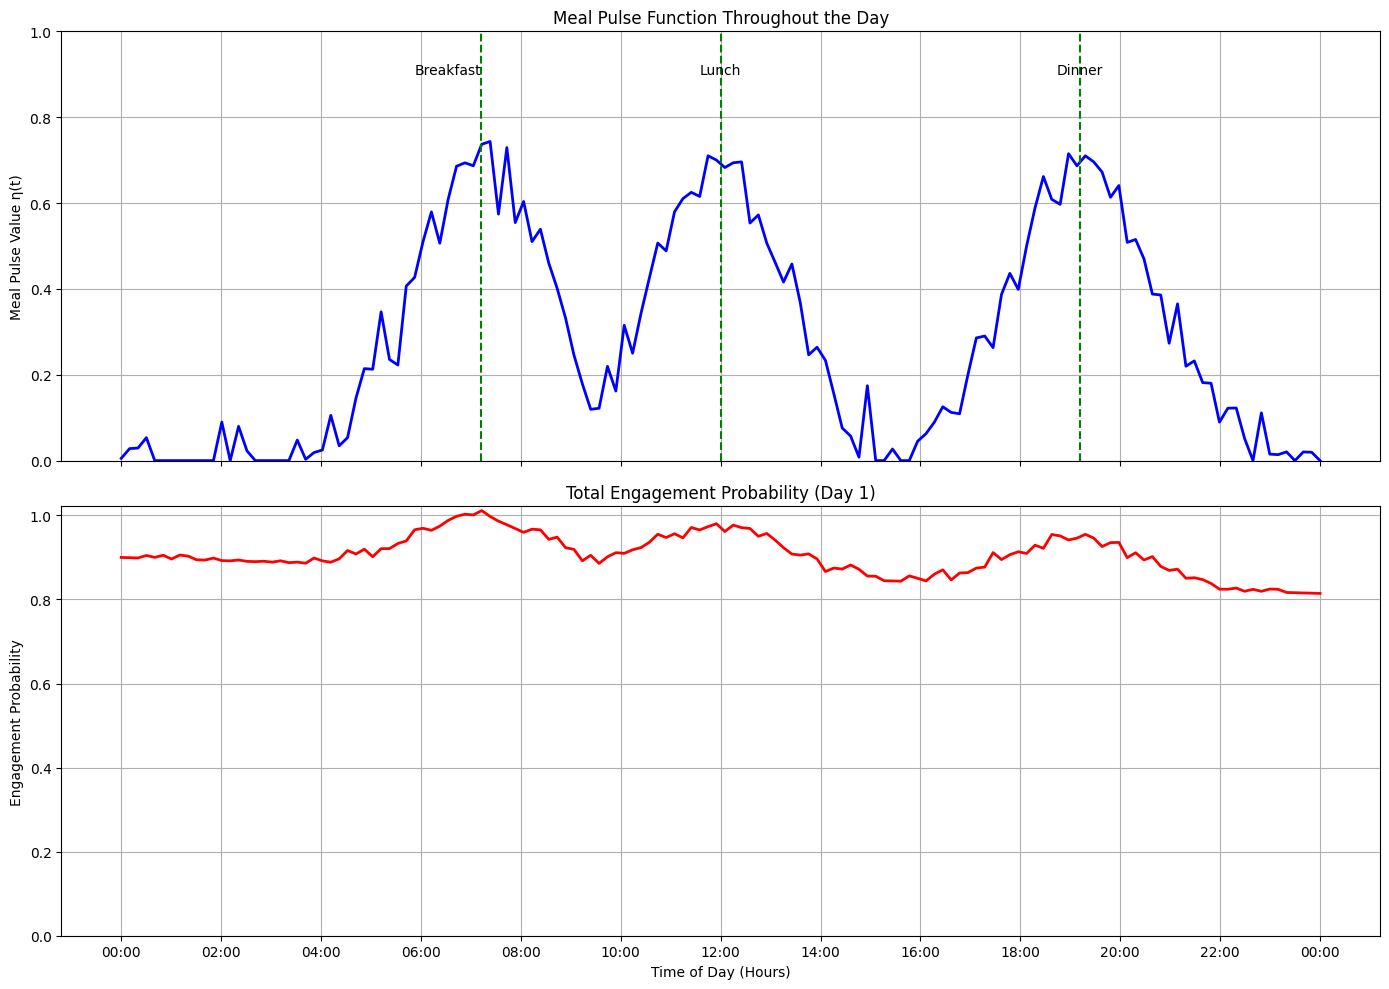

<Figure size 640x480 with 0 Axes>

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
import datetime as dt

minutes_per_day = 24 * 60
time_points = np.linspace(0, 1, minutes_per_day // 10)
base_date = dt.datetime(2025, 1, 1)
times = [base_date + dt.timedelta(days=t) for t in time_points]

pulse_values = [meal_pulse(t,sigma) for t in time_points]

base_engagement_values = [base_engagement(p0,beta,t) for t in time_points]

engagement_prob = [survival_engagement(p0,beta,t,sigma,gamma) for t in time_points]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot meal pulse function η(t)
ax1.plot(times, pulse_values, 'b-', linewidth=2)
ax1.set_ylabel('Meal Pulse Value η(t)')
ax1.set_title('Meal Pulse Function Throughout the Day')
ax1.grid(True)
ax1.set_ylim(0, 1)

# Mark meal times
meal_times = [
    base_date + dt.timedelta(days=0.3),  # breakfast
    base_date + dt.timedelta(days=0.5),   # lunch
    base_date + dt.timedelta(days=0.8)   # dinner
]
meal_labels = ["Breakfast", "Lunch", "Dinner"]

for i, (time, label) in enumerate(zip(meal_times, meal_labels)):
    ax1.axvline(x=time, color='g', linestyle='--')
    ax1.text(time, 0.9, label, horizontalalignment='right' if i == 0 else 'center')

# Plot total engagement probability
ax2.plot(times, engagement_prob, 'r-', linewidth=2)
ax2.set_ylabel('Engagement Probability')
ax2.set_title(f'Total Engagement Probability (Day {day})')
ax2.grid(True)
ax2.set_ylim(bottom=0)

# Format x-axis to show hours
ax2.xaxis.set_major_locator(HourLocator(interval=2))
ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax2.set_xlabel('Time of Day (Hours)')

# Add base engagement line for reference
#ax2.axhline(y=E_t, color='k', linestyle=':', label=f'Base Engagement (E_t = {E_t:.3f})')
#ax2.legend()

plt.tight_layout()
plt.show()

# Now let's create a 3D visualization of how this changes over multiple days
#from mpl_toolkits.mplot3d import Axes3D
#
#fig = plt.figure(figsize=(14, 10))
#ax = fig.add_subplot(111, projection='3d')

## Create meshgrid for days and time of day
#days_to_show = 10
#days_range = np.arange(1, days_to_show + 1)
#times_of_day = np.linspace(0, 1, 48)  # 48 points throughout day
#
#X, Y = np.meshgrid(times_of_day, days_range)
#Z = np.zeros_like(X)
#
## Calculate engagement probability for each point
#for i, day in enumerate(days_range):
#    for j, tod in enumerate(times_of_day):
#        E_t = p0 * np.exp(-beta * day)
#        R_t = 1 + gamma * meal_pulse(tod)
#        Z[i, j] = E_t * R_t
#
## Convert X to hour format for better visualization
#X_hours = X * 24
#
## Create the surface plot
#surf = ax.plot_surface(X_hours, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
#
## Add labels and colorbar
#ax.set_xlabel('Hour of Day')
#ax.set_ylabel('Day')
#ax.set_zlabel('Engagement Probability')
#ax.set_title('Engagement Probability Over Days and Hours')
#
## Add meal time indicators
#for hour in [6, 12, 18]:  # Meal hours
#    ax.plot([hour, hour], [1, days_to_show], [0, 0], 'g--', alpha=0.5)
#
#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

In [43]:
def run_simulation(p0, beta, sigma, gamma, max_messages_per_day, alpha):
    # Initialize data structures
    time_points_per_day = 24  # Hourly resolution
    total_time_points = days * time_points_per_day
    time_array = np.linspace(0, days, total_time_points)
    
    # Track messages per user per day
    user_messages = np.zeros((num_users, days))
    
    # Track if user is still active in the study
    user_active = np.ones(num_users, dtype=bool)
    
    # For each time point
    for t_idx, t in enumerate(time_array):
        current_day = int(t)
        
        # For each user
        for user_idx in range(num_users):
            if not user_active[user_idx]:
                continue
                
            # Get number of messages already sent today
            messages_sent_today = user_messages[user_idx, current_day]
            
            # If user hasn't reached daily limit
            if messages_sent_today < max_messages_per_user_per_day:
                # Calculate probability of sending a message
                p_engage = calculate_engagement_probability(
                    p0, beta, t, sigma, gamma, 
                    messages_sent_today, max_messages_per_day, alpha
                )
                
                # Determine if user sends a message
                if np.random.random() < p_engage:
                    # User sends a message
                    user_messages[user_idx, current_day] += 1
            
            # Check if user drops out of study
            if np.random.random() > q:  # Dropout probability = 1-q per time step
                user_active[user_idx] = False
    
    return user_messages

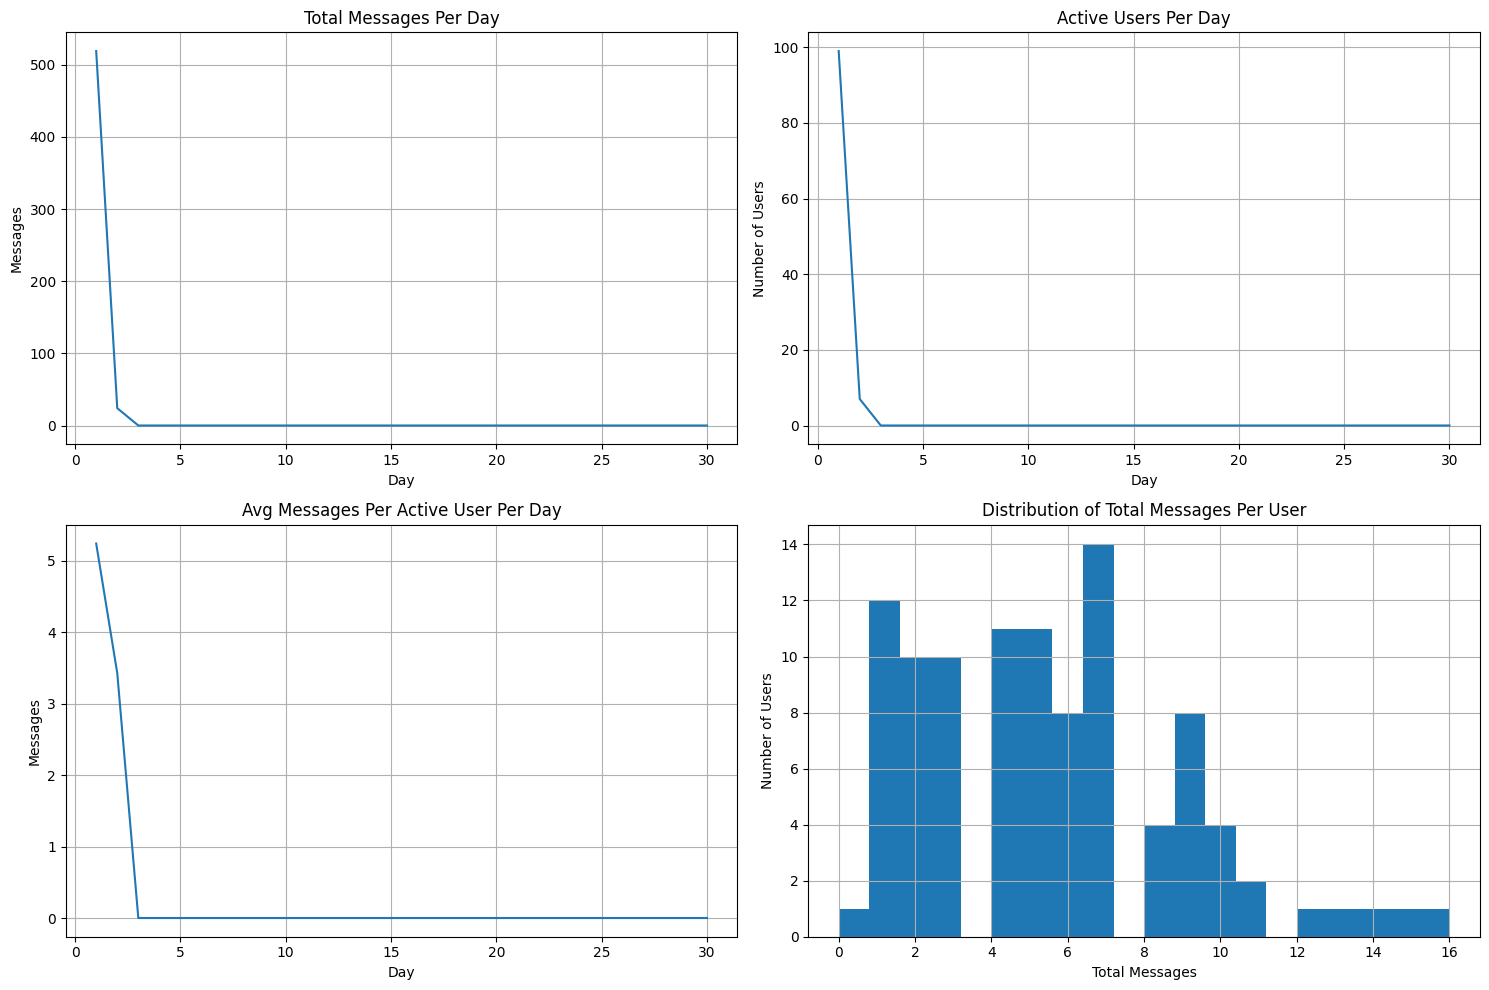

Total messages in simulation: 543.0
Average messages per user: 5.43
Active users on final day: 0


In [50]:
# Simulation parameters
days = 30
num_users = 100
p0 = 0.9        # Initial engagement probability
beta = 0.01     # Engagement decay rate
q = 0.9   
sigma = 0.08  
gamma = 0.2     # Meal-time re-engagement modulation strength
max_messages_per_user_per_day = 10  # Daily message limit per user
geo_p = 1

user_messages = run_simulation(p0, beta, sigma, gamma, max_messages_per_user_per_day, geo_p)

avg_messages_per_day = np.mean(user_messages, axis=0)
total_messages_per_day = np.sum(user_messages, axis=0)
active_users_per_day = np.sum(user_messages > 0, axis=0)
avg_messages_per_active_user = np.zeros(days)
for d in range(days):
    active_users = np.sum(user_messages[:, d] > 0)
    if active_users > 0:
        avg_messages_per_active_user[d] = np.sum(user_messages[:, d]) / active_users

# Create visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, days+1), total_messages_per_day)
plt.title('Total Messages Per Day')
plt.xlabel('Day')
plt.ylabel('Messages')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(range(1, days+1), active_users_per_day)
plt.title('Active Users Per Day')
plt.xlabel('Day')
plt.ylabel('Number of Users')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(range(1, days+1), avg_messages_per_active_user)
plt.title('Avg Messages Per Active User Per Day')
plt.xlabel('Day')
plt.ylabel('Messages')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(np.sum(user_messages, axis=1), bins=20)
plt.title('Distribution of Total Messages Per User')
plt.xlabel('Total Messages')
plt.ylabel('Number of Users')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print overall statistics
print(f"Total messages in simulation: {np.sum(user_messages)}")
print(f"Average messages per user: {np.mean(np.sum(user_messages, axis=1))}")
print(f"Active users on final day: {np.sum(user_messages[:, -1] > 0)}")

In [ ]:
from response.response_manager import process_openai_response, send_interim_response
import threading


body = "Salut mon chatbot préféré"
from_number = "+33647873573"

response_data = {'response': None, 'sent': False}
timer = threading.Timer(5.0, send_interim_response, [from_number, response_data])
timer.start()
resp = process_openai_response(app,from_number,body,response_data,timer,None,"SMS")
        timer.start()
        threading.Thread(target=process_openai_response, args=(
            current_app._get_current_object(), from_number, body, response_data, timer, twilio_message_id  # type: ignore
        )).start()

In [4]:
def load_data(user_food_df):
    """
    Load and prepare the food and category data.
    
    Args:
        user_food_df (pd.DataFrame): The user's food data
        
    Returns:
        pd.DataFrame: Prepared user data with categories
    """
    
    project_dir = os.getcwd()
    data_dir = os.path.join(project_dir, DATA_FOLDER_NAME)
    
    foods_export_path = os.path.join(data_dir, FOODS_EXPORT_FILENAME)
    category_list_path = os.path.join(data_dir, FOODS_CATEGORIES_FILENAME)   
    products_path = os.path.join(data_dir, PRODUCTS_FILENAME)
    products_category_list_path = os.path.join(data_dir, PRODUCTS_CATEGORIES_FILENAME)
    
    # Load the food & products export data
    food_export = pd.read_csv(foods_export_path)
    product_export = pd.read_csv(products_path)
    
    # Load the category list data
    category_list = pd.read_csv(category_list_path)
    products_category_list = pd.read_csv(products_category_list_path)
    
    # Get food category columns (excluding food_name)
    food_categories = [col for col in category_list.columns if col != "food_name"]
    
    # Prepare products data with combined name and categories
    product_export["name_combined"] = (
        product_export["name_en"]
        .fillna(product_export["name_fr"])
        .fillna(product_export["name_de"])
    )
    
    # Create products with categories - merge on food_name column
    products_with_categories = pd.merge(
        product_export, 
        products_category_list, 
        how='left',  # Use left join to keep all products
        left_on='name_combined', 
        right_on='food_name',
        suffixes=('_product', '_category')
    )
    
    # Prepare foods with categories - merge category list with food export
    foods_with_categories = pd.merge(
        food_export,
        category_list,
        left_on="display_name_en", 
        right_on="food_name", 
        how="left",
        suffixes=('_food', '_category')
    )
    
    # Load and prepare user data
    user_df = user_food_df.copy()
    user_df["local_time"] = pd.to_datetime(user_df["local_time"], errors='coerce')
    user_df["eaten_date"] = user_df["local_time"].dt.date
    user_df["eaten_hour"] = user_df["local_time"].dt.hour
    user_df["eaten_time"] = user_df["local_time"].dt.time
    
    #print("Initial user_df shape:", user_df.shape)
    
    # Initialize category columns with False
    for category in food_categories:
        user_df[category] = False
    
    # Track matching statistics
    food_matches = 0
    product_matches = 0
    total_foods = 0
    total_products = 0
    
    # Process each row individually to handle foods and products correctly
    for idx, row in user_df.iterrows():
        # Check if this row has a food_id (it's a food item)
        if pd.notna(row.get('food_id')) and pd.notna(row.get('food_name')):
            total_foods += 1
            # Try to match with foods_with_categories using food_name
            food_match = foods_with_categories[
                foods_with_categories['food_name_en'] == row['food_name']
            ]
            
            
            if not food_match.empty:
                #print(f"Matched: {row['food_name']}")
                food_matches += 1
                # Update category columns for this food
                for category in food_categories:
                    if category in food_match.columns:
                        category_value = food_match.iloc[0][category]
                        if pd.notna(category_value):
                            user_df.at[idx, category] = category_value
        
        # Check if this row has a product_id (it's a product item)
        elif pd.notna(row.get('product_id')) and pd.notna(row.get('product_name')):
            total_products += 1
            # Try to match with products_with_categories using product_name
            product_match = products_with_categories[
                products_with_categories['name_combined'] == row['product_name']
            ]
            
            if not product_match.empty:
                product_matches += 1
                # Update category columns for this product
                for category in food_categories:
                    if category in product_match.columns:
                        category_value = product_match.iloc[0][category]
                        if pd.notna(category_value):
                            user_df.at[idx, category] = category_value
    
        print(f"Final user_df shape: {user_df.shape}")
        print(f"Food matching: {food_matches}/{total_foods} foods matched")
        print(f"Product matching: {product_matches}/{total_products} products matched")
        print("Available category columns:", [col for col in food_categories if col in user_df.columns])
    
    # Display some sample matches for debugging
    matched_foods = user_df[user_df[food_categories].any(axis=1)]
    #print(f"Total rows with category matches: {len(matched_foods)}")
    
    if len(matched_foods) > 0:
        #print("\nSample of matched items:")
        sample_cols = ['food_name', 'product_name'] + food_categories[:5] if len(food_categories) >= 5 else food_categories
        #print(matched_foods[sample_cols].head())
    
    return user_df, products_with_categories, foods_with_categories

In [4]:
def get_users_emails() :
    base_directory = os.getcwd()
    #base_directory = os.path.abspath(os.path.dirname(__file__))
    #project_directory = os.path.join(base_directory, '..', '..')
    project_directory = os.getcwd()
    data_directory = os.path.join(project_directory,'data')
    users_data_file = os.path.join(data_directory,'google_form_users_data.csv')

    users_complete_data = pd.read_csv(users_data_file,dtype={'Phone Number': str})

    users_complete_data = users_complete_data[['Phone Number', 'E-mail Address']]

    return users_complete_data

In [ ]:
ancient_products = pd.read_csv('data/products_category_list.csv')

new_products = pd.read_csv('data/other_products.csv')

ancient_products = ancient_products.loc[:, ~ancient_products.columns.str.contains('^Unnamed')]
unique_new_products = new_products[~new_products['food_name'].isin(ancient_products['food_name'])]
combined_products = pd.concat([ancient_products, unique_new_products], ignore_index=True)


combined_products.to_csv('data/all_products_category_list.csv', index=False)